## Defensive Technical Analysis strategy

The Defensive Technical Analysis strategy focuses on a more conservative approach by utilizing the Stochastic Oscillator and MACD indicators to generate buy and sell signals for the MAANG stocks over the same 5-year period. The strategy employs the following indicators: 

Stochastic Oscillator: This is a momentum indicator that compares a particular closing price of a security to a range of its prices over a certain period. The strategy calculates the Stochastic Oscillator with a 14-day lookback period and a 3-day signal line period. A buy signal is generated when the Stochastic Oscillator is below 20, and a sell signal is generated when it is above 80. 

Moving Average Convergence Divergence (MACD): This is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price. The MACD is calculated using the 12-day and 26-day EMAs, along with a 9-day signal line. A buy signal is generated when the MACD line crosses above the signal line, and a sell signal is generated when the MACD line crosses below the signal line. 

The final buy or sell decision is made when both indicators agree on the same signal. When both indicators agree to sell a stock, and there are no buy signals for any other stocks on that same day, the sell transaction is executed and the proceeds from the sale are then evenly distributed among the remaining four stocks in the portfolio. When both indicators agree to sell a stock, and there is/are buy signals for other stock(s) on the same day, the proceeds from the sale are used to buy only the buy signal stock(s). 

In [149]:
import pandas as pd
import yfinance as yf  # Yahoo Finance API for fetching stock data
import matplotlib.pyplot as plt
import numpy as np

In [150]:
# Define MAANG stocks and time period
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
start_date = '2014-12-01'
end_date = '2019-12-31'

columns_to_drop = ['High', 'Low', 'Dividends', 'Stock Splits']
result_df = pd.DataFrame()

for each_stock in tickers:
    stock_data = yf.Ticker(each_stock)
    hist_stock_data = stock_data.history(start = start_date, end = end_date)
    hist_stock_data_copy = hist_stock_data.copy()
    hist_stock_data_copy = hist_stock_data_copy.drop(columns_to_drop, axis=1)
    hist_stock_data_copy.columns = [each_stock + '_' + col for col in hist_stock_data_copy.columns]
    result_df = pd.concat([result_df, hist_stock_data_copy], axis=1)

In [151]:
#calculate stochastic oscillator
def calculate_SO(df, window_size_K, window_size_D ):
    
    for each_stock in tickers:
        stock_close_column = each_stock + '_Close'
        stock_SO_K = each_stock + '_SO_K'
        stock_SO_D = each_stock + '_SO_D'
        stock_Highest_L14 = each_stock + '_Highest_in_L14'
        stock_Lowest_L14 = each_stock + '_Lowest_in_L14'
        stock_recent_price = each_stock + '_recent_price'
        stock_SO_Buy_Sell_decision = each_stock + '_SO_B/S_Decision'
        df[stock_Highest_L14] = df[stock_close_column].rolling(window=window_size_K).max()
        df[stock_Lowest_L14] = df[stock_close_column].rolling(window=window_size_K).min()
        df[stock_recent_price] = df[stock_close_column]
        df[stock_SO_K] = ((df[stock_recent_price] - df[stock_Lowest_L14])/(df[stock_Highest_L14] - df[stock_Lowest_L14])) * 100 
        df[stock_SO_D] = df[stock_SO_K].rolling(window=window_size_D).mean()
        conditions = [(df[stock_SO_D] < 25),(df[stock_SO_D] > 75)]
        choices = ['Buy','Sell']
        df[stock_SO_Buy_Sell_decision] = np.select(conditions, choices, default='NA')
        temp_columns = [stock_Highest_L14, stock_Lowest_L14, stock_recent_price]
        df = df.drop(temp_columns, axis=1)
    return df

In [152]:
#calculate MACD
def calculate_MACD(df):
    for each_stock in tickers:
        stock_close_column = each_stock + '_Close'
        stock_MACD = each_stock + '_MACD'
        stock_signal_MACD = each_stock + '_signal_MACD'
        stock_signal_MACD_diff = each_stock + '_signal_MACD_diff'
        stock_MACD_Buy_Sell_decision = each_stock + '_MACD_B/S_Decision'
        Short_EMA = df[stock_close_column].ewm(span=12, adjust=False).mean()
        Long_EMA = df[stock_close_column].ewm(span=26, adjust=False).mean()
        MACD = Short_EMA - Long_EMA
        signal = MACD.ewm(span=9, adjust=False).mean()
        df[stock_MACD] = MACD
        df[stock_signal_MACD] = signal
        df[stock_signal_MACD_diff] = df[stock_MACD] - df[stock_signal_MACD]
        conditions = [
            (df[stock_signal_MACD_diff] > 0) & (df[stock_signal_MACD_diff].shift(1) < 0), 
            (df[stock_signal_MACD_diff] < 0) & (df[stock_signal_MACD_diff].shift(1) > 0) 
        ]
        choices = ['Buy','Sell']
        df[stock_MACD_Buy_Sell_decision] = np.select(conditions, choices, default='NA')   
    return df

In [153]:
#finalise Buy/Sell
def final_buy_sell(df):
    for each_stock in tickers:
        stock_SO_Buy_Sell_decision = each_stock + '_SO_B/S_Decision'
        stock_MACD_Buy_Sell_decision = each_stock + '_MACD_B/S_Decision'
        stock_Final_BorS_Decision = each_stock + '_Final_BorS_Decision'
        conditions = [
            (df[stock_SO_Buy_Sell_decision] == "Buy") & (df[stock_MACD_Buy_Sell_decision] == "Buy"), 
            (df[stock_SO_Buy_Sell_decision] == "Sell") & (df[stock_MACD_Buy_Sell_decision] == "Sell")
        ]
        choices = ['Buy','Sell']
        df[stock_Final_BorS_Decision] = np.select(conditions, choices, default='NA')
    return df

In [154]:
result_df = calculate_SO(result_df, 21, 5)
result_df = calculate_MACD(result_df)
result_df = final_buy_sell(result_df)

In [155]:
for each_stock in tickers:
    stock_Final_BorS_Decision = each_stock + '_Final_BorS_Decision'
    print(each_stock)
    print(result_df[stock_Final_BorS_Decision].value_counts())

META
NA      1244
Sell      26
Buy        9
Name: META_Final_BorS_Decision, dtype: int64
AAPL
NA      1243
Sell      28
Buy        8
Name: AAPL_Final_BorS_Decision, dtype: int64
AMZN
NA      1245
Sell      29
Buy        5
Name: AMZN_Final_BorS_Decision, dtype: int64
NFLX
NA      1243
Sell      30
Buy        6
Name: NFLX_Final_BorS_Decision, dtype: int64
GOOGL
NA      1249
Sell      24
Buy        6
Name: GOOGL_Final_BorS_Decision, dtype: int64


In [156]:
#Buy and selling of shares following the strategy based on the B/S signals from SO and MACD
def execute_buy_sell(df):
    df.index = pd.to_datetime(df.index)
    df['Cash Balance'] = 0
    initial_date = pd.Timestamp('2015-01-02')
    initial_date = initial_date.tz_localize(None)
    #df.loc['2015-01-02', 'Cash balance'] = 1000000
    
    #Add columns for shares owned & initial allocation
    for stock in tickers:
        df[stock + '_owned_shares'] = 0 
        if stock + '_Open' in df.columns:  
            initial_price = df.loc['2015-01-02', stock + '_Open']
            #print(initial_price)
            df.loc['2015-01-02', stock + '_owned_shares'] = round(200000 / initial_price)

    start_index = df.index.get_loc(initial_date) + 1
    
    # Iterate over the DataFrame for next day execution based on the previous day's decisions
    for i in range(start_index, len(df.index)):
        current_date = df.index[i]
        previous_date = df.index[i - 1]

        # Initialize daily cash balance based on the previous day's ending balance
        daily_cash_balance = df.at[previous_date, 'Cash Balance']

        buy_stocks = []
        sell_stocks = []

        for stock in tickers:
            decision_column = stock + '_Final_BorS_Decision'  # Adjust based on actual column names
            if df.at[previous_date, decision_column] == 'Buy':
                #print(current_date, " - Buy - " ,stock)
                buy_stocks.append(stock)
            elif df.at[previous_date, decision_column] == 'Sell':
                #print(current_date, " - Sell - " , stock)
                sell_stocks.append(stock)
        
        # Execute sells first to update the cash balance
        if sell_stocks:
            for stock in sell_stocks:
                print(current_date, " - Sell - " ,stock)
                sell_price = df.at[current_date, stock + '_Open']
                print("Selling price ", sell_price)
                shares_to_sell = df.at[previous_date, stock + '_owned_shares']
                print("Previous date ", previous_date)
                print("Stocks owned on previous date (shares to sell): ", shares_to_sell)
                daily_cash_balance = daily_cash_balance + (sell_price * shares_to_sell) # Increase cash balance
                print("Cash Balance after selling shares: ", daily_cash_balance)
                df.at[current_date, stock + '_owned_shares'] = 0  # Reset shares to 0 after selling
                print("Shares owned on current date after selling: ", df.at[current_date, stock + '_owned_shares'])   
            if not buy_stocks:
                all_stocks = set(tickers)
                sell_set = set(sell_stocks)
                not_sell = all_stocks - sell_set
                buy_stocks = list(not_sell)
                print("Not sell stocks: ",not_sell)
                print("buy_stocks list after selling shares: ",buy_stocks)
        # Execute buys with the updated cash balance
        if buy_stocks:
            cash_per_stock = daily_cash_balance / len(buy_stocks) if daily_cash_balance > 0 else 0
            for stock in buy_stocks:
                if cash_per_stock > 0:
                    print(current_date, " - Buy - " ,stock)
                    buy_price = df.at[current_date, stock + '_Open']
                    print("Buying price ", buy_price)
                    shares_to_buy = round(cash_per_stock / buy_price)
                    print("Previous date ", previous_date)
                    print("Stocks owned on previous date: ", df.at[previous_date, stock + '_owned_shares'])
                    print("Shares to buy: ", shares_to_buy)
                    df.at[current_date, stock + '_owned_shares'] = df.at[previous_date, stock + '_owned_shares'] + shares_to_buy  # Add bought shares
                    print("Shares owned after buying: ", df.at[current_date, stock + '_owned_shares'])
                    daily_cash_balance = daily_cash_balance - (shares_to_buy * buy_price)  # Deduct spent cash
                else:
                    df.at[current_date, stock + '_owned_shares'] = df.at[previous_date, stock + '_owned_shares']
                    
        all_stocks = set(tickers)
        buy_set = set(buy_stocks)
        sell_set = set(sell_stocks)
        
        no_transaction_stocks = all_stocks - (buy_set.union(sell_set))
        print(current_date, 'No transaction stocks : ' , no_transaction_stocks)
        for stock in no_transaction_stocks:
            df.at[current_date, stock + '_owned_shares'] = df.at[previous_date, stock + '_owned_shares']

        # Update the cash balance at the end of the day
        df.at[current_date, 'Cash Balance'] = daily_cash_balance
    
    return df

In [157]:
#Calculation of the Portfolio value if 1M is invested through the Strategy 2: Defensive Entry Points
def calculate_portfolio_value(df):
    df.index = pd.to_datetime(df.index)
    df['Portfolio Value'] = 0
    initial_date = pd.Timestamp('2015-01-02')
    initial_date = initial_date.tz_localize(None)
    start_index = df.index.get_loc(initial_date)
    
    portfolio_value = 0
    current_date = df.index[start_index]
    #calculating the portfolio value on day 1 - 2015/01/02
    for stock in tickers:
        stock_value = df.at[current_date, stock + '_owned_shares'] * df.at[current_date, stock +'_Close']
        portfolio_value = portfolio_value + stock_value
    df.at[current_date, 'Portfolio Value'] = portfolio_value
    
    start_index = df.index.get_loc(initial_date) + 1
    
    # len(df.index)
    for i in range(start_index, len(df.index)): 
        portfolio_value = 0
        current_date = df.index[i]
        #print(current_date)
        for stock in tickers:
            stock_value = df.at[current_date, stock + '_owned_shares'] * df.at[current_date, stock +'_Close']
            portfolio_value = portfolio_value + stock_value
            #print(current_date, ' ', portfolio_value)
        #print(portfolio_value)
        df.at[current_date, 'Portfolio Value'] = portfolio_value
    
    return df

In [158]:
#Removal of initial few rows (out of our required period) which were used for the SO and MACD calculation
def remove_unnecessary_initial_rows(df):
    df.index = pd.to_datetime(df.index)
    initial_date = pd.Timestamp('2015-01-02')
    df = df.loc[initial_date:]
    return df

In [159]:
result_df = execute_buy_sell(result_df)

/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_14972/898819920.py:17: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_index = df.index.get_loc(initial_date) + 1


2015-01-05 00:00:00-05:00 No transaction stocks :  {'NFLX', 'AAPL', 'META', 'GOOGL', 'AMZN'}
2015-01-06 00:00:00-05:00 No transaction stocks :  {'NFLX', 'AAPL', 'META', 'GOOGL', 'AMZN'}
2015-01-07 00:00:00-05:00 No transaction stocks :  {'NFLX', 'AAPL', 'META', 'GOOGL', 'AMZN'}
2015-01-08 00:00:00-05:00 No transaction stocks :  {'NFLX', 'AAPL', 'META', 'GOOGL', 'AMZN'}
2015-01-09 00:00:00-05:00 No transaction stocks :  {'NFLX', 'AAPL', 'META', 'GOOGL', 'AMZN'}
2015-01-12 00:00:00-05:00 No transaction stocks :  {'NFLX', 'AAPL', 'META', 'GOOGL', 'AMZN'}
2015-01-13 00:00:00-05:00 No transaction stocks :  {'NFLX', 'AAPL', 'META', 'GOOGL', 'AMZN'}
2015-01-14 00:00:00-05:00 No transaction stocks :  {'NFLX', 'AAPL', 'META', 'GOOGL', 'AMZN'}
2015-01-15 00:00:00-05:00 No transaction stocks :  {'NFLX', 'AAPL', 'META', 'GOOGL', 'AMZN'}
2015-01-16 00:00:00-05:00 No transaction stocks :  {'NFLX', 'AAPL', 'META', 'GOOGL', 'AMZN'}
2015-01-20 00:00:00-05:00 No transaction stocks :  {'NFLX', 'AAPL', 'M

2016-05-27 00:00:00-04:00 No transaction stocks :  {'NFLX', 'AAPL', 'META', 'GOOGL', 'AMZN'}
2016-05-31 00:00:00-04:00 No transaction stocks :  {'NFLX', 'AAPL', 'META', 'GOOGL', 'AMZN'}
2016-06-01 00:00:00-04:00 No transaction stocks :  {'NFLX', 'AAPL', 'META', 'GOOGL', 'AMZN'}
2016-06-02 00:00:00-04:00 No transaction stocks :  {'NFLX', 'AAPL', 'META', 'GOOGL', 'AMZN'}
2016-06-03 00:00:00-04:00 No transaction stocks :  {'NFLX', 'AAPL', 'META', 'GOOGL', 'AMZN'}
2016-06-06 00:00:00-04:00 No transaction stocks :  {'NFLX', 'AAPL', 'META', 'GOOGL', 'AMZN'}
2016-06-07 00:00:00-04:00 No transaction stocks :  {'NFLX', 'AAPL', 'META', 'GOOGL', 'AMZN'}
2016-06-08 00:00:00-04:00 No transaction stocks :  {'NFLX', 'AAPL', 'META', 'GOOGL', 'AMZN'}
2016-06-09 00:00:00-04:00 No transaction stocks :  {'NFLX', 'AAPL', 'META', 'GOOGL', 'AMZN'}
2016-06-10 00:00:00-04:00 No transaction stocks :  {'NFLX', 'AAPL', 'META', 'GOOGL', 'AMZN'}
2016-06-13 00:00:00-04:00 No transaction stocks :  {'NFLX', 'AAPL', 'M

In [160]:
result_df = calculate_portfolio_value(result_df)

/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_14972/3152976944.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_index = df.index.get_loc(initial_date)
/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_14972/3152976944.py:17: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_index = df.index.get_loc(initial_date) + 1


In [161]:
#Removal of initial few rows (out of our required period) which were used for the SO and MACD calculation
result_df = remove_unnecessary_initial_rows(result_df)
print(len(result_df))

1257


/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_14972/1369410887.py:5: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  df = df.loc[initial_date:]


In [162]:
#Calculation of the portfolio value if 1M had been invested equally in the start of the specified period
def calculate_no_strategy_portfolio_value(df):
    for stock in tickers:
        stock_initial_owned = stock + 'initial_owned'
        stock_initial_owned = result_df.at[result_df.index[0], stock + '_owned_shares']
        print("Initial stocks owned: ", stock_initial_owned) 
    
    df.index = pd.to_datetime(df.index)
    df['NS Portfolio Value'] = 0
    initial_date = pd.Timestamp('2015-01-02')
    initial_date = initial_date.tz_localize(None)
    start_index = df.index.get_loc(initial_date)
    
    for i in range(start_index, len(df.index)): 
        ns_portfolio_value = 0
        current_date = df.index[i]
        #print(current_date)
        for stock in tickers:
            stock_initial_owned = stock + 'initial_owned'
            stock_initial_owned = result_df.at[result_df.index[0], stock + '_owned_shares']
            #print("Initial stocks owned: ", stock_initial_owned)
            stock_value = stock_initial_owned * df.at[current_date, stock +'_Close']
            ns_portfolio_value = ns_portfolio_value + stock_value
            #print(current_date, ' ', portfolio_value)
            #print(portfolio_value)
        print("NS Portfolio Value: ", ns_portfolio_value)
        df.at[current_date, 'NS Portfolio Value'] = ns_portfolio_value
    return df

In [163]:
result_df = calculate_no_strategy_portfolio_value(result_df)

/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_14972/200953070.py:12: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_index = df.index.get_loc(initial_date)


Initial stocks owned:  2548
Initial stocks owned:  8034
Initial stocks owned:  12797
Initial stocks owned:  4069
Initial stocks owned:  7510
NS Portfolio Value:  995078.0879182816
NS Portfolio Value:  968177.9103689194
NS Portfolio Value:  953024.0122070312
NS Portfolio Value:  958125.0409526825
NS Portfolio Value:  976912.031586647
NS Portfolio Value:  968419.3369941711
NS Portfolio Value:  949880.7417039871
NS Portfolio Value:  957728.9392595291
NS Portfolio Value:  957413.8950214386
NS Portfolio Value:  941343.220211029
NS Portfolio Value:  955469.8848352432
NS Portfolio Value:  968704.3823165894
NS Portfolio Value:  1015544.6913843155
NS Portfolio Value:  1048828.356171608
NS Portfolio Value:  1058641.7294855118
NS Portfolio Value:  1059596.3013324738
NS Portfolio Value:  1044837.9314861298
NS Portfolio Value:  1045174.242360115
NS Portfolio Value:  1062215.1191167831
NS Portfolio Value:  1089094.2841091156
NS Portfolio Value:  1093318.9351501465
NS Portfolio Value:  1103436.226598

NS Portfolio Value:  3708016.7702789307
NS Portfolio Value:  3750806.091529846
NS Portfolio Value:  3645680.0428619385
NS Portfolio Value:  3692773.143623352
NS Portfolio Value:  3612682.927467346
NS Portfolio Value:  3651181.9098968506
NS Portfolio Value:  3665946.0690078735
NS Portfolio Value:  3686785.438987732
NS Portfolio Value:  3735294.003967285
NS Portfolio Value:  3701368.4655532837
NS Portfolio Value:  3751350.268371582
NS Portfolio Value:  3751437.650894165
NS Portfolio Value:  3782273.6291503906
NS Portfolio Value:  3827941.7097702026
NS Portfolio Value:  3805349.119255066
NS Portfolio Value:  3796829.275238037
NS Portfolio Value:  3804863.4344711304
NS Portfolio Value:  3814747.039352417
NS Portfolio Value:  3813131.8538360596
NS Portfolio Value:  3819864.4117279053
NS Portfolio Value:  3768984.9376831055
NS Portfolio Value:  3797619.6332702637
NS Portfolio Value:  3830183.929473877
NS Portfolio Value:  3872536.197654724
NS Portfolio Value:  3873406.3193740845
NS Portfolio

In [164]:
#calculation of portfolio value if 1M was invested in the S&P index at the start of the specified period
def calculate_SP_500_value(df):
    ticker_symbol = "^GSPC"
    start_date = "2015-01-01"
    end_date = "2019-12-31"
    sp500_data = yf.download(ticker_symbol, start=start_date, end=end_date)
    sp500_data.index = pd.to_datetime(sp500_data.index)
    
    sp500_data.to_csv("SP500.csv")
    
    sp500_units_for_1M = round(1000000/sp500_data.at['2015-01-02', 'Open'])
    #print(sp500_units_for_1M)
    
    df.index = df.index.date
    
    df['SP_500'] = sp500_data['Close']
    df['SP_500_Value'] = sp500_units_for_1M * df['SP_500']
    
    return df

In [165]:
result_df = calculate_SP_500_value(result_df)

[*********************100%%**********************]  1 of 1 completed


In [166]:
def calculate_metrics(df):
    #Calculation of returns
    initial_portfolio_value = 1000000 #1M was split and invested equally initially
    print("Initial Investment: ", initial_portfolio_value)
    print("------------------------------------------------")
    #strategy
    final_portfolio_value = result_df.at[result_df.index[-1], 'Portfolio Value']
    strategy_returns = ((final_portfolio_value-initial_portfolio_value)/(initial_portfolio_value)) * 100
    print("Final strategy portfolio value: ", final_portfolio_value)
    print("Strategy Returns: ", round(strategy_returns, 2), "%")
    print("------------------------------------------------")
    #no_strategy
    final_ns_portfolio_value = result_df.at[result_df.index[-1], 'NS Portfolio Value']
    ns_strategy_returns = ((final_ns_portfolio_value-initial_portfolio_value)/(initial_portfolio_value)) * 100
    print("Final equal split portfolio value: ", final_ns_portfolio_value)
    print("No Strategy Returns (Equal Split): ", round(ns_strategy_returns, 2), "%")
    print("------------------------------------------------")
    #S&P500
    final_sp500_value = result_df.at[result_df.index[-1], 'SP_500_Value']
    sp500_returns = ((final_sp500_value-initial_portfolio_value)/(initial_portfolio_value)) * 100
    print("Final SP_500 value: ", final_sp500_value)
    print("SP 500 Returns: ", round(sp500_returns, 2), "%")
    print("------------------------------------------------")
    #Annualized returns CAGR
    annualised_strategy_returns = ((1 + (strategy_returns/100)) ** (1/5)) - 1
    annualised_ns_returns = ((1 + (ns_strategy_returns/100)) ** (1/5)) - 1
    annualised_sp_returns = ((1 + (sp500_returns/100)) ** (1/5)) - 1
    
    print(f"Strategy returns (Annualised): {annualised_strategy_returns * 100:.2f}%")
    print(f"No Strategy returns (Annualised): {annualised_ns_returns * 100:.2f}%")
    print(f"SP returns (Annualised): {annualised_sp_returns * 100:.2f}%")
    
    df['Strategy_Portfolio_DReturns'] = df['Portfolio Value'].pct_change()
    df['NS_Portfolio_DReturns'] = df['NS Portfolio Value'].pct_change()
    df['SP_500_DReturns'] = df['SP_500_Value'].pct_change()
    
    #Calculation of risk
    strategy_risk = df['Strategy_Portfolio_DReturns'].std()
    ns_risk = df['NS_Portfolio_DReturns'].std()
    sp_500_risk = df['SP_500_DReturns'].std()
    print("------------------------------------------------")
    print(f"Strategy risk (Daily): {strategy_risk * 100:.2f}%")
    print(f"No Strategy risk (Daily): {ns_risk * 100:.2f}%")
    print(f"SP 500 (Daily): {sp_500_risk * 100:.2f}%")
    print("------------------------------------------------")
    print(f"Strategy risk (Monthly): {strategy_risk * np.sqrt(21) * 100:.2f}%")
    print(f"No Strategy risk (Monthly): {ns_risk * np.sqrt(21) * 100:.2f}%")
    print(f"SP 500 risk (Monthly): {sp_500_risk * np.sqrt(21) * 100:.2f}%")
    print("------------------------------------------------")
    print(f"Strategy risk (Annualised): {strategy_risk * np.sqrt(252) * 100:.2f}%")
    print(f"No Strategy risk (Annualised): {ns_risk * np.sqrt(252) * 100:.2f}%")
    print(f"SP 500 risk (Annualised): {sp_500_risk * np.sqrt(252) * 100:.2f}%")
    print("------------------------------------------------")
    
    print("Performance metrics of the Strategy")
    #Calculating Sharpe ratio of strategy
    annualised_strategy_risk = strategy_risk * np.sqrt(252)
    risk_free_rate = 0.0227 #calculated as the average yield of the 10-year t-bill rate over the given 5 year period
    sharpe_ratio = (annualised_strategy_returns - risk_free_rate)/annualised_strategy_risk
    print(f"Sharpe Ratio : {sharpe_ratio:.2f}")
    #Calculating Sortino ratio of strategy
    negative_daily_returns = df['Strategy_Portfolio_DReturns'][df['Strategy_Portfolio_DReturns'] < 0]
    downside_deviation = np.std(negative_daily_returns) * np.sqrt(252)
    sortino_ratio = (annualised_strategy_returns - risk_free_rate) / downside_deviation
    print(f"Sortino Ratio: {sortino_ratio:.2f}")
    #Calculating beta of the strategy
    covariance = df['Strategy_Portfolio_DReturns'].cov(df['SP_500_DReturns'])
    market_variance = df['SP_500_DReturns'].var()
    beta = covariance / market_variance
    print(f"Beta of the Strategy: {beta:.2f}")
    #Calculating alpha of the strategy
    alpha = annualised_strategy_returns - (risk_free_rate + beta * (annualised_sp_returns - risk_free_rate))
    print(f"Alpha of the Strategy: {alpha:.4f}")
    print("------------------------------------------------")
    return df

In [167]:
#Print the returns and metrics
result_df = calculate_metrics(result_df)

Initial Investment:  1000000
------------------------------------------------
Final strategy portfolio value:  6216484.508865356
Strategy Returns:  521.65 %
------------------------------------------------
Final equal split portfolio value:  4090329.8648986816
No Strategy Returns (Equal Split):  309.03 %
------------------------------------------------
Final SP_500 value:  1565546.958984375
SP 500 Returns:  56.55 %
------------------------------------------------
Strategy returns (Annualised): 44.11%
No Strategy returns (Annualised): 32.54%
SP returns (Annualised): 9.38%
------------------------------------------------
Strategy risk (Daily): 1.53%
No Strategy risk (Daily): 1.56%
SP 500 (Daily): 0.85%
------------------------------------------------
Strategy risk (Monthly): 7.01%
No Strategy risk (Monthly): 7.15%
SP 500 risk (Monthly): 3.88%
------------------------------------------------
Strategy risk (Annualised): 24.29%
No Strategy risk (Annualised): 24.76%
SP 500 risk (Annualised):

In [168]:
result_df.to_csv("result_v1.csv")

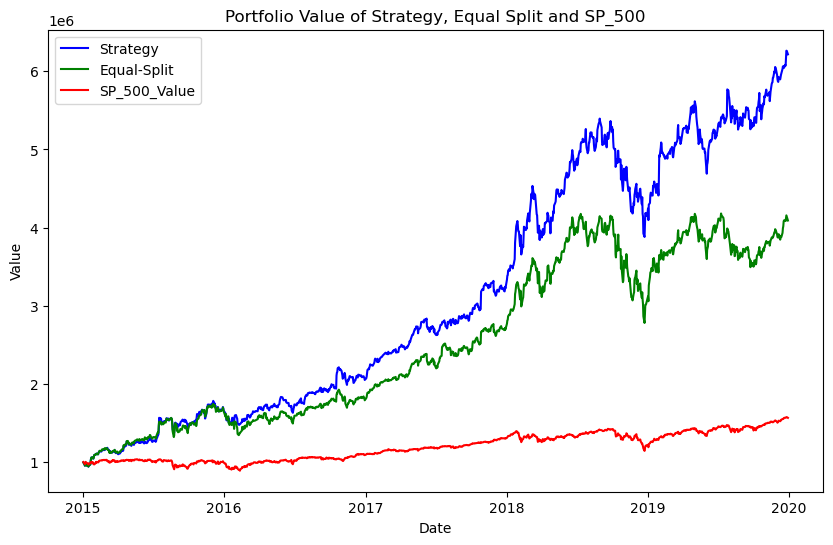

In [169]:
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.plot(result_df.index, result_df['Portfolio Value'], label='Strategy', color='blue')  # Line for Column1
plt.plot(result_df.index, result_df['NS Portfolio Value'], label='Equal-Split', color='green')  # Line for Column2
plt.plot(result_df.index, result_df['SP_500_Value'], label='SP_500_Value', color='red')  # Line for Column3

# Adding title and labels
plt.title('Portfolio Value of Strategy, Equal Split and SP_500')
plt.xlabel('Date')
plt.ylabel('Value')

# Show legend
plt.legend()

# Display the plot
plt.show()

The max drawdown is -1514131.8325424194 or -28.07%


<Figure size 1000x500 with 0 Axes>

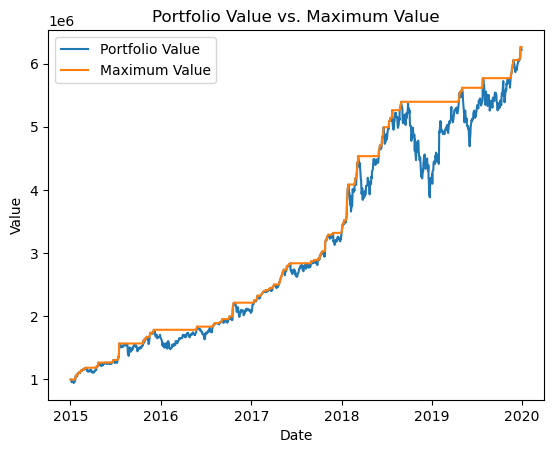

<Figure size 1000x500 with 0 Axes>

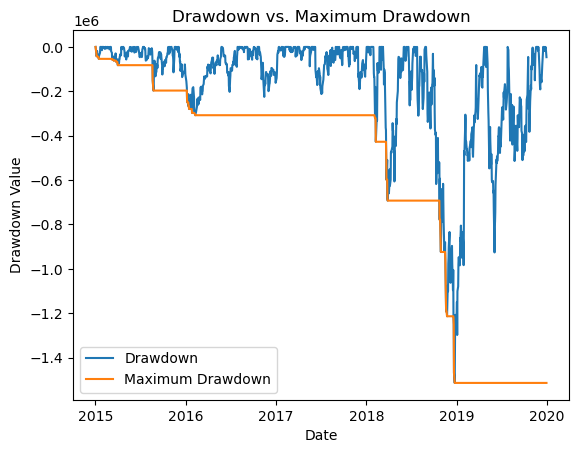

In [170]:
# Cumulative Max
result_df['Maximum Value'] = result_df['Portfolio Value'].cummax()

# Store the differences in a new colum "drawdowns"
# Note that we are calculating the drawdowns from cumsum of returns which is already in percentage.
result_df['Drawdown'] = result_df['Portfolio Value'] - result_df['Maximum Value']
result_df['Drawdown (%)'] = result_df['Drawdown']/result_df['Maximum Value']
result_df['Maximum Drawdown'] = result_df['Drawdown'].cummin()

# The maximum difference is refered as "Drawdown"
max_drawdown = result_df['Drawdown'].min()
max_drawdown_percent = result_df['Drawdown (%)'].min()
print("The max drawdown is", max_drawdown, "or", str(round(max_drawdown_percent*100,2))+"%")

#Visualise how these two look like
plt.figure(figsize=(10, 5))
result_df[['Portfolio Value', 'Maximum Value']].dropna().plot()
plt.xlabel('Date')  # X-axis label
plt.ylabel('Value')  # Y-axis label
plt.title('Portfolio Value vs. Maximum Value')  # Adding a title for clarity
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
result_df[['Drawdown', 'Maximum Drawdown']].dropna().plot()
plt.xlabel('Date')  # X-axis label
plt.ylabel('Drawdown Value')  # Y-axis label
plt.title('Drawdown vs. Maximum Drawdown')  # Adding a title for clarity
plt.legend()
plt.show()